In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np

import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

###Import self-written library
import featexlib.debug as dbug
import featexlib.datagen as dgen

Out shape X,Y is: (100000, 84, 84) (100000, 1)
Show first 10 images:


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


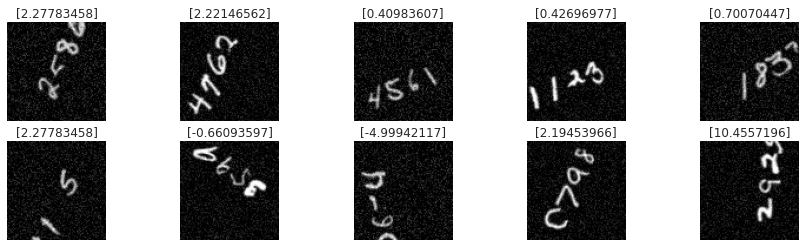

In [2]:
###Load data
###This cell should be used in another cell Can be used in another file

x_load, y_load = dgen.Image_generator.load_data(name="base_c20_rot_shift_84x84_tan_angle")

###Get information about dataset
y_max = y_load.max()

###Show some report. Label is uniq for each class but it doesnt related to "real" image values
print("===================================")
print("Out shape X,Y is:",x_load.shape, y_load.shape)
print("Show first 10 images:")
dbug.Debug.show_images_list(x_load[:10], y_load[:10], col_number = 5)

pic_h = x_load.shape[1]
pic_w = x_load.shape[2]
num_classes = 1

In [3]:
###Split data to test and train
n_train = 70000
n_test = 5000

def relabel_y(inp_y):
    inp_y_uniq = len(np.unique(inp_y))
    inp_y_max = inp_y.max()

    print("Number of classes:",inp_y_uniq)
    print("Max class label:", inp_y_max)
    print("Relabeling is not required" if (inp_y_max+1)==inp_y_uniq else "Y should be relabeled to 0-n")

    if not (inp_y_max+1)==inp_y_uniq:
        lookup_table = dict(zip(np.unique(inp_y), np.arange(len(np.unique(inp_y)))) )
        vect_lookup = np.vectorize(lookup_table.get)
        out_y = np.copy(inp_y)
        out_y = vect_lookup(out_y)
        print("Y was relabeled")
        print("New number of classes:", len(np.unique(out_y)))
        print("New max class label:", out_y.max())
        return out_y
    else:
        return inp_y

###Get X train and test
x_train, x_test = x_load[:n_train], x_load[n_train:n_train+n_test]
y_train, y_test = y_load[:n_train], y_load[n_train:n_train+n_test]

print("===============Data is ready====================")
print("Shape X,Y for train:",x_train.shape,y_train.shape)
print("Shape X,Y for test: ",x_test.shape,y_test.shape)

###Clean memory
del x_load, y_load

===============Data is ready====================
Shape X,Y for train: (70000, 84, 84) (70000, 1)
Shape X,Y for test:  (5000, 84, 84) (5000, 1)


In [4]:
###Reshape and then rescale dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1))
x_test  = scaler.transform(x_test.reshape(x_test.shape[0],-1))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(70000, 7056) (70000, 1) (5000, 7056) (5000, 1)


In [5]:
###Prepare for training: check labels dimension (-1), change X to float32 instead of float64
ys = y_train.reshape(-1)
xs = x_train.astype('float32').reshape(-1,pic_h,pic_w,1)
#ys_one_hot = tf.one_hot(ys, num_classes) ###not used

ys_test = y_test.reshape(-1)
xs_test = x_test.astype('float32').reshape(-1,pic_h,pic_w,1)

###Clear memory
del x_train, y_train, y_test, x_test

In [6]:
print(xs.shape, ys.shape, xs_test.shape, ys_test.shape)

(70000, 84, 84, 1) (70000,) (5000, 84, 84, 1) (5000,)


In [6]:
###Model parameters

#'num_classes' is defined before

def angle_net(input_size = (pic_h,pic_w,1)):
    
    inputs = tf.keras.Input(shape=input_size)
    conv1 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conv1)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),  padding='same')(conv2)
    conv3 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.2)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.2)(conv5)

    flat = tf.keras.layers.Flatten()(pool1)

    out_dense = tf.keras.layers.Dense(1)(flat)
    
    model = tf.keras.Model(inputs = inputs, outputs = out_dense)

    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'mse', metrics = ['mse'])
    
    return model


In [7]:
###Create model
model = angle_net()
bunch_len = 256
dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset_batches = dataset.batch(bunch_len)

In [13]:
model.fit(xs, ys, batch_size=256, epochs=6)

Epoch 1/6
274/274 [==============================] - 697s 3s/step - loss: 2.7425 - mse: 2.7425
Epoch 2/6
274/274 [==============================] - 691s 3s/step - loss: 2.6979 - mse: 2.6979
Epoch 3/6
274/274 [==============================] - 686s 3s/step - loss: 2.6749 - mse: 2.6749
Epoch 4/6
274/274 [==============================] - 697s 3s/step - loss: 2.6426 - mse: 2.6426
Epoch 5/6
274/274 [==============================] - 693s 3s/step - loss: 2.5957 - mse: 2.5957
Epoch 6/6
274/274 [==============================] - 693s 3s/step - loss: 2.5871 - mse: 2.5871


In [14]:
###Save model after training
model.save_weights('./models/angle')

In [15]:
#Get predictions and features for test dataframe
y_pred = model(xs_test)

In [16]:
#(xs_test - xs_test.min())/(xs_test.max()-xs_test.min()).shape

ys_test

array([2.11915901, 2.03714779, 1.4437982 , ..., 0.42696977, 1.77499174,
       2.03714779])

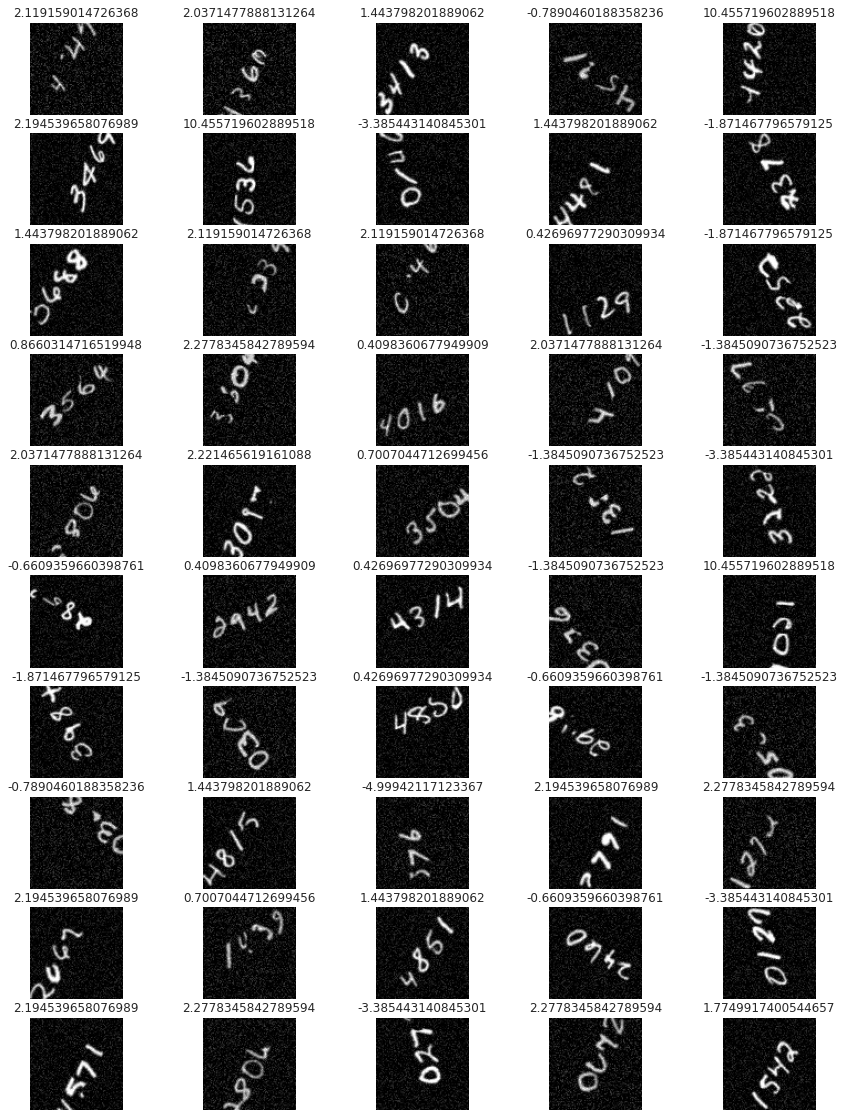

In [17]:
dbug.Debug.show_images_list(scaler.inverse_transform(xs_test.reshape(-1,7056)).reshape(-1,84,84)[:50].reshape(-1,pic_h,pic_w), ys_test[:50], col_number = 5)

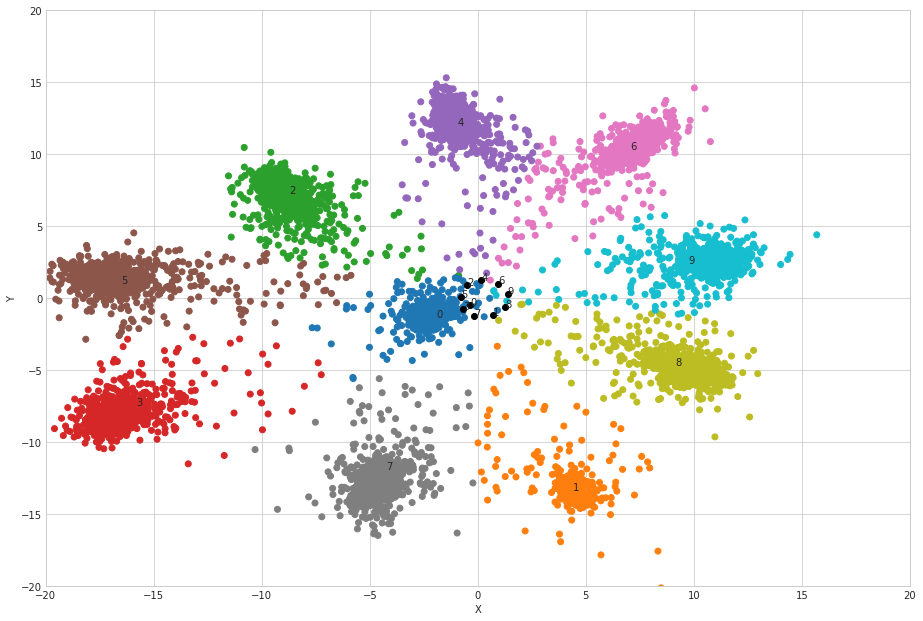

array([[ -1.9242867 ,  -1.2769696 ],
       [  4.4159355 , -13.351339  ],
       [ -8.732005  ,   7.309432  ],
       [-15.808876  ,  -7.420747  ],
       [ -0.93458784,  12.040671  ],
       [-16.497854  ,   1.0617944 ],
       [  7.046907  ,  10.372195  ],
       [ -4.2405353 , -11.8541565 ],
       [  9.1233015 ,  -4.6500025 ],
       [  9.741671  ,   2.439099  ]], dtype=float32)

<tf.Variable 'dense_3/kernel:0' shape=(2, 10) dtype=float32, numpy=
array([[ 0.88432413,  0.68028337, -0.6672186 ,  1.2843869 , -0.15179698,
         1.276881  ,  0.08845953, -1.0143772 ,  0.2778069 , -0.8433039 ],
       [-1.3016163 ,  1.279158  , -1.2335091 , -0.55072093,  1.2718129 ,
         0.6290787 , -1.4957021 , -0.35204726,  0.9666587 ,  0.6032002 ]],
      dtype=float32)>